# Deep Learning Inversion - MT Case
## Part 1 - Making Training Dataset
#### Leo Dinendra - https://github.com/leocd91

## Intro

The magnetotelluric (MT) method is a geophysical technique used to study the Earth's subsurface by measuring natural variations of electric and magnetic fields at the Earth's surface.

The primary measurements are the apparent resistivity and phase of the natural electromagnetic signals recorded at the Earth's surface (or sometimes using Controlled Source in certain methods). The apparent resistivity is a combination of the true subsurface resistivity and the effects of the Earth's layered structure on the incoming electromagnetic waves. By analyzing variations in apparent resistivity and phase at different frequencies, geophysicists can invert these data to obtain models of subsurface resistivity. The output of the inversion process provides information about the distribution of resistivity.

### Challenges

- Predict the model based on measured data to monitor parameter changes.
- Further advance the model into a data-driven solution to invert the measured data (?)

<img src="./src/1.jpg" alt="Alt text" width="600"/>

## Importing Packages & Functions Needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from MT2D import * #credits : MT2DFD by Zhong Pheng https://github.com/zhongpenggeo/MT2DFD
import os
from matplotlib.colors import LogNorm
from scipy.ndimage import convolve
from tqdm import tqdm

### Setting dataset location

In [2]:
folder_name = './dataset'
# Check if the folder exists
if not os.path.exists(folder_name):
    # If not, create the folder
    os.makedirs(folder_name)

### Survey / Forward Modelling Parameter

In [3]:
alpha = 2.0 # smoothness of gaussian random field,the larger the more smooth;
nza = 0 # number of air layer
y = 6e3    # lenght in left and right
z = 4e3    # depth
size_b = 10 # nodes of expand domain
size_k = 47 # nodes of kernel domain
n_freq = 48  # number of frequency data generated
alpha = 3.0
mode = 'random' # if random, 下面是mean和std，if bounda, 是lower和upper
set_1 = 100.0
set_2 = 100.0

## Function for smoothing & making model

In [4]:
def smooth_2d_array(arr, kernel_size=3):
    '''
    arr : 2D array input
    kernel_size : a NxN kernel for smoothing using convolution
    '''
    # Define a kernel (e.g., a simple 3x3 averaging kernel)
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    # Apply convolution to smooth the array
    smoothed_array = convolve(arr, kernel, mode='nearest')

    return smoothed_array

In [5]:
def generate_model(nza, y, z, size_b, size_k, n_freq, alpha = 3.0, mode='random', set_1=100.0, set_2=100.0):
    '''
    nza   : number of air layer
    y     : [-y,y]
    z     : [0,z]: 
    size_b: number of nodes from boundary to kernel domain
    size_k: kernel domain,
    n_freq: number of frequency
    alpha : smoothness of gaussian random field,the larger the more smooth;
    mode  : if random, 下面是mean和std，if bounda, 是lower和upper
    '''
    z_air = np.linspace(-z,0,nza+1)
    zn0 = np.linspace(0, z, size_k+1)
    z_b = np.linspace(zn0[-1],2*zn0[-1],size_b+1)
    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))

    yn0 = np.linspace(-y,y,size_k+1)
    y_l = np.linspace(2*yn0[0],yn0[0],size_b+1)
    y_r = np.linspace(yn0[-1],2*yn0[-1],size_b+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))
    
    freq = np.logspace(3,-3,n_freq)
    ry = np.linspace(-y,y,size_k+1)

    sig = np.ones((size_b+size_k+nza,2*size_b+size_k))*1e-2
    #sig[:nza,:] = 1e-9 # If you want to make an air layer, uncomment these & give parameter to nza
    sig[:15,:] = 1
    sig[15:25,:] = 10
    sig[25:35,20:45]= 100
    
    return zn, yn, freq, ry, sig

In [6]:
zn, yn, freq, ry, sig = generate_model(nza, y, z, size_b, size_k, n_freq, alpha, mode, set_1, set_2)
model = MT2DFD(nza, zn, yn, freq, ry, sig)
sig = smooth_2d_array(sig, kernel_size=3)
rhoxy, phsxy,Zxy,rhoyx,phsyx,Zyx  = model.mt2d("TETM")

In [7]:
yn0 = np.linspace(-y,y,size_k+1)

In [8]:
zn0 = np.linspace(0, z, size_k+1)

## Model Visualization

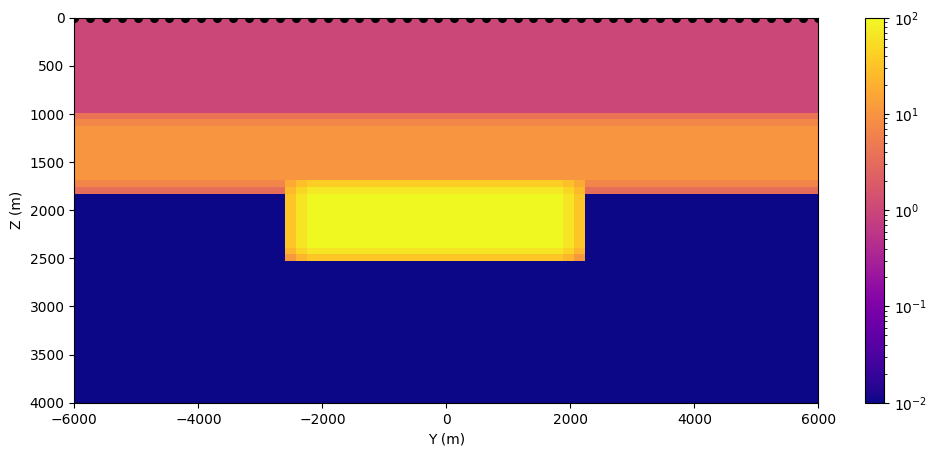

In [9]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
h = ax.imshow(sig, interpolation='nearest', cmap='plasma', norm=LogNorm(vmin=sig.min(), vmax=sig.max()),
              extent=[yn0.min(), yn0.max(), zn0.min(), zn0.max()], 
              origin='lower', aspect='auto')
ax.invert_yaxis()
for y_position in yn0:
    ax.scatter(y_position, zn.min(), color='black', marker='o', s=30, label='Measurement Location')
ax.set_ylabel("Z (m)")
ax.set_xlabel("Y (m)")
fig.colorbar(h)
plt.show()

The parameter changes in the yellow area are the ones that we will monitor.

Black dots in the surface are the position where we will measure the data.

## Theoritical Data Generated by Forward Modelling Visualization

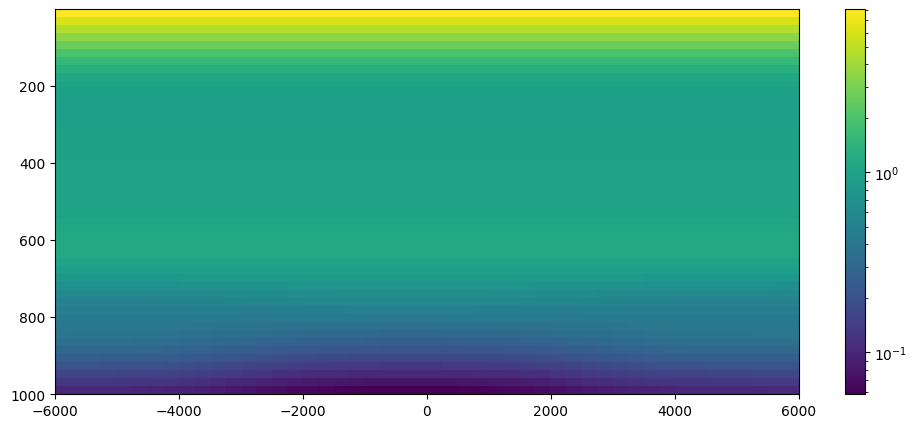

In [10]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
h = ax.imshow(rhoyx, interpolation='nearest', cmap='viridis', norm=LogNorm(vmin=rhoyx.min(), vmax=rhoyx.max()), 
              extent=[yn0.min(), yn0.max(), freq.min(), freq.max()], 
              origin='lower', aspect='auto')
ax.invert_yaxis()
fig.colorbar(h)
plt.show()

## Graph of Data Measured in the middle

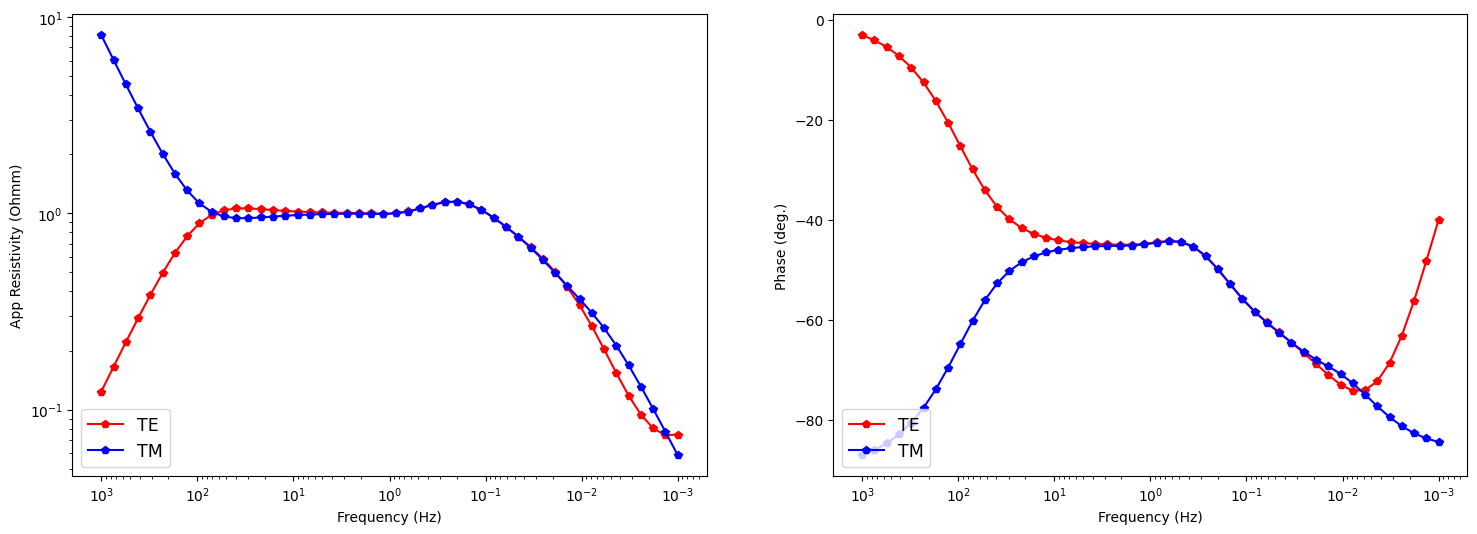

In [11]:
measure_position = 24 #middle
fig = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax.plot(freq, rhoxy[:,measure_position], 'rp-',label="TE")
ax.plot(freq, rhoyx[:,measure_position], 'bp-',label="TM")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("App Resistivity (Ohmm)")
ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
ax = plt.subplot(1,2,2)
ax.plot(freq, phsxy[:,measure_position], 'rp-',label="TE")
ax.plot(freq, phsyx[:,measure_position]-180, 'bp-',label="TM")
ax.set_xscale("log")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Phase (deg.)")
ax.invert_xaxis()
ax.legend(loc='lower left',fontsize=12.5)
plt.show()

## Generating model parameter between 90-500 ohmm

In [12]:
for i in tqdm(range(1000)):
    fname1 = 'rhoxy%04d.npy'%i
    fname2 = 'rhoyx%04d.npy'%i
    fname3 = 'phsxy%04d.npy'%i
    fname4 = 'phsyx%04d.npy'%i
    fname5 = 'model%04d.npy'%i
    zn, yn, freq, ry, sig = generate_model(nza, y, z, size_b, size_k, n_freq, alpha, mode, set_1, set_2)
    sig[sig==100] = 90 + i*0.5 
    sig = smooth_2d_array(sig, kernel_size=3)
    np.save(folder_name+'//'+fname5, sig.astype('float32'))
    model = MT2DFD(nza, zn, yn, freq, ry, sig)
    rhoxy, phsxy,Zxy,rhoyx,phsyx,Zyx  = model.mt2d("TETM")
    np.save(folder_name+'//'+fname1, rhoxy.astype('float32'))
    np.save(folder_name+'//'+fname2, rhoyx.astype('float32'))
    np.save(folder_name+'//'+fname3, phsxy.astype('float32'))
    np.save(folder_name+'//'+fname4, phsyx.astype('float32'))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [39:21<00:00,  2.36s/it]


All dataset files needed for training the deep learning model is in the dataset folder.

In [13]:
i=500


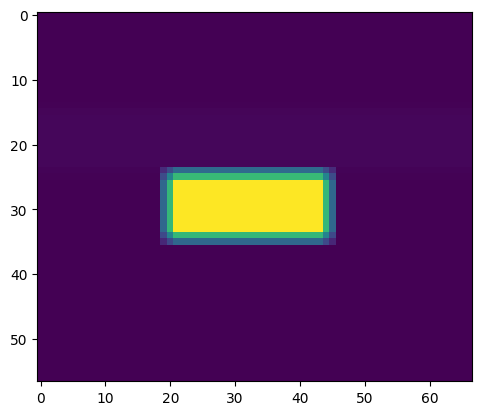

In [14]:
plt.imshow(sig.astype('float32'))

In [15]:
sig = np.load(folder_name+'//'+'model0500.npy')

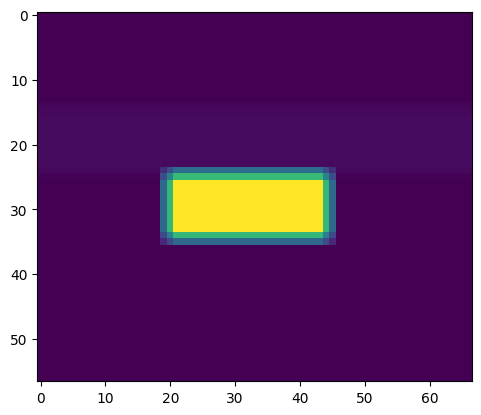

In [16]:
plt.imshow(sig)

In [17]:
fname5

'model0999.npy'

In [18]:
rhoxy.min()

0.041404214296223055

In [19]:
rhoxy.max()

1.1397345863423884

In [20]:
logrhoxy = np.log(rhoxy)

In [21]:
logrhoxy.min()

-3.184372608736827

In [22]:
logrhoxy.max()

0.13079541630194896